## Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

In [1]:
# import wget
# wget.download("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py")

In [2]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you will have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Get 10% of training data of 10 classes of Food101
# import wget
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip")

# unzip_data("10_food_classes_10_percent.zip")

In [4]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# Create training and test directory paths
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
%load_ext tensorboard

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.45612244e+02 1.41612244e+02 1.30612244e+02]
   [1.42974487e+02 1.38974487e+02 1.27974487e+02]
   [1.45852036e+02 1.41852036e+02 1.30852036e+02]
   ...
   [1.87158249e+02 1.71586777e+02 1.36811279e+02]
   [1.76571472e+02 1.58571472e+02 1.21765327e+02]
   [1.87785812e+02 1.68142960e+02 1.30071533e+02]]

  [[1.42408173e+02 1.38408173e+02 1.27408165e+02]
   [1.43137756e+02 1.39137756e+02 1.28137756e+02]
   [1.41397949e+02 1.37397949e+02 1.26397957e+02]
   ...
   [1.82928696e+02 1.66000122e+02 1.37245071e+02]
   [1.92448914e+02 1.73448914e+02 1.43168274e+02]
   [1.84219360e+02 1.63290787e+02 1.32096909e+02]]

  [[1.39362244e+02 1.35362244e+02 1.24362244e+02]
   [1.41000000e+02 1.37000000e+02 1.26000000e+02]
   [1.39428558e+02 1.35428558e+02 1.24428574e+02]
   ...
   [1.82255219e+02 1.63403122e+02 1.37928665e+02]
   [1.87719315e+02 1.66933609e+02 1.39933609e+02]
   [1.71270111e+02 1.50270111e+02 1.23270103e+02]]

  ...

  [[1.28469543e+01 1.18469543e+01 7.84695435e+00]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [11]:
# 1. Create base model with tf.keras.applications
from pickletools import optimize


base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SHAPE, name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221013-101908
Epoch 1/5
24/24 [==============================] - 19s 703ms/step - loss: 1.8034 - accuracy: 0.4600 - val_loss: 1.2400 - val_accuracy: 0.7697
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 1.0611 - accuracy: 0.7627 - val_loss: 0.8366 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 16s 686ms/step - loss: 0.7767 - accuracy: 0.8187 - val_loss: 0.6502 - val_accuracy: 0.8618
Epoch 4/5
24/24 [==============================] - 16s 690ms/step - loss: 0.6237 - accuracy: 0.8773 - val_loss: 0.5844 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 16s 681ms/step - loss: 0.5417 - accuracy: 0.8867 - val_loss: 0.5228 - val_accuracy: 0.8717


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 30s 377ms/step - loss: 0.5418 - accuracy: 0.8628


[0.5417777895927429, 0.8628000020980835]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


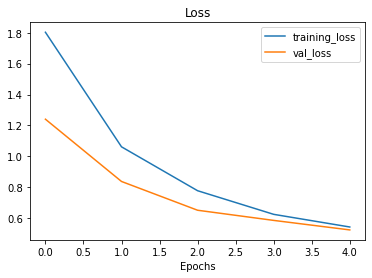

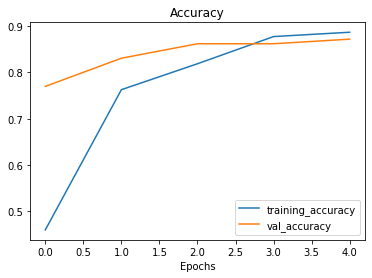

In [16]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

# %tensorboard --logdir "transfer_learning"

## Getting a feature vector from a trained model

Let's demonstracte the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tesnor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

 🛠 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

In [19]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


In [20]:
# Let's replicate the GlobalMaxPooling2D layer
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is, is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample. In our case, this is the output of the `tf.keras.layers.GlobalAvergaePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [21]:
# Download and unzip data - preprocessed from Food101
# import wget
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip")

# unzip_data("10_food_classes_1_percent.zip")

In [22]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [23]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [24]:
# Setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    layers.Input(shape=IMG_SHAPE),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255),  # Keep for models like ResNet50V2 but EfficientNet's having rescale built-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

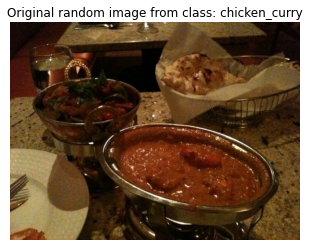

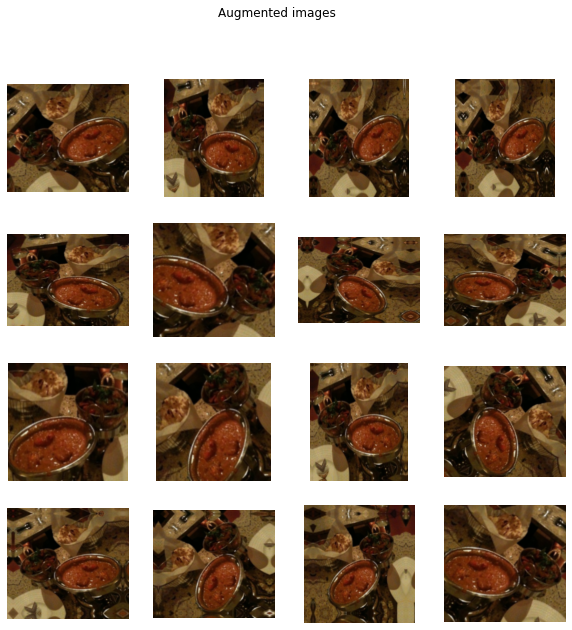

In [26]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
plt.figure(figsize=(10, 10))
plt.suptitle("Augmented images")
for i in range(16):
    resized_img = tf.expand_dims(tf.image.resize(img, size=IMG_SIZE), axis=0)
    augmented_img = data_augmentation(resized_img, training=True)
    plt.subplot(4, 4, i + 1)
    plt.imshow(tf.squeeze(augmented_img, axis=0)/255.)
    plt.axis(False)


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [27]:
# Setup input shape and base model, freezing the base model layers
input_shape = IMG_SHAPE
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              # Track model training logs
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221013-102104
Epoch 1/5
3/3 [==============================] - 12s 4s/step - loss: 2.4235 - accuracy: 0.1429 - val_loss: 2.2217 - val_accuracy: 0.1990
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.1585 - accuracy: 0.2286 - val_loss: 2.0953 - val_accuracy: 0.2615
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.9505 - accuracy: 0.4143 - val_loss: 1.9756 - val_accuracy: 0.3355
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.7692 - accuracy: 0.6286 - val_loss: 1.8787 - val_accuracy: 0.4128
Epoch 5/5
3/3 [==============================] - 8s 4s/step - loss: 1.5871 - accuracy: 0.6000 - val_loss: 1.7845 - val_accuracy: 0.4441


In [28]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [29]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 29s 369ms/step - loss: 1.7846 - accuracy: 0.4644


[1.7845773696899414, 0.4643999934196472]

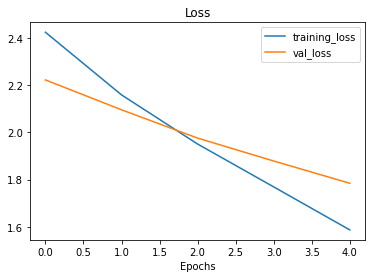

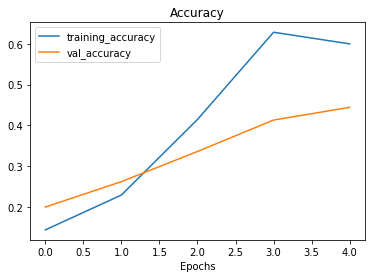

In [30]:
# How do the model with 1% of the training data and data augmentation loss curves look?
plot_loss_curves(history_model_1)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [31]:
# Get 10% of data... (uncomment if you don't have it)
# import wget
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip")

# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [32]:
# Set data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
# Create model 2 with data augmentation built in
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Rescaling
from tensorflow.keras.models import Sequential

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = Sequential([
    Input(shape=IMG_SHAPE),
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    # Rescaling(1./255),  # Keep for models like ResNet50V2 but EfficientNet's having rescale built-in
], name="data_augmentation")

In [34]:
IMG_SHAPE = IMG_SIZE + (3,)

# Setup input shape to our model
input_shape = IMG_SHAPE

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)  # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False)  # pass augmented images to base model
# We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that
# batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.
# https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create model
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come back and start where we left off.

In [35]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpont callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",   # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [36]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              # Track model training logs
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221013-102218
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9573 - accuracy: 0.3707
Epoch 1: saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 20s 742ms/step - loss: 1.9573 - accuracy: 0.3707 - val_loss: 1.4324 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2866 - accuracy: 0.7067
Epoch 2: saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 16s 693ms/step - loss: 1.2866 - accuracy: 0.7067 - val_loss: 0.9783 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0.7853
Epoch 3: saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 17s 726ms/step - loss: 0.9562 - accuracy: 0.7853 - val_loss: 0.7712 - val_accuracy: 0.8240
Epoc

In [37]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 30s 374ms/step - loss: 0.5418 - accuracy: 0.8628


[0.5417779088020325, 0.8628000020980835]

In [38]:
# Evaluate on the full test dataset
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 30s 377ms/step - loss: 0.6151 - accuracy: 0.8400


[0.6150757670402527, 0.8399999737739563]

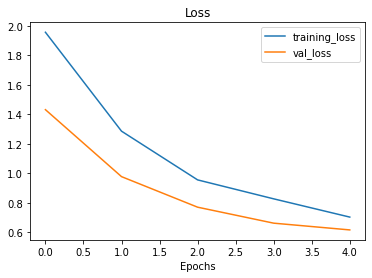

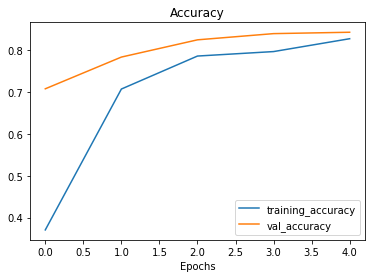

In [39]:
# Plot model loss curves
plot_loss_curves(history_model_2)

### Loading in checkpointed weights

Loading in checkpointed weitghts returns a model to a specific checkpoint.

In [40]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [41]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 30s 377ms/step - loss: 0.6151 - accuracy: 0.8400


In [42]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [43]:
results_10_percent_data_aug

[0.6150757670402527, 0.8399999737739563]

In [44]:
loaded_weights_model_results

[0.6150758266448975, 0.8399999737739563]

In [45]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np

np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [46]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [47]:
# Layers in loaded model
model_2.layers

In [48]:
# Are these layers trainable
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001CBEF9FDC10> True
<keras.engine.sequential.Sequential object at 0x000001CBEF65FE20> True
<keras.engine.functional.Functional object at 0x000001CC0898EC10> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001CBEF9FC7F0> True
<keras.layers.core.dense.Dense object at 0x000001CC08CADF40> True


In [49]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_5 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [50]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [51]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

> 🔑 **Note:** When fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).

A good resource for information on this is the UMLFit paper: https://arxiv.org/abs/1801.06146

In [52]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [53]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [54]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_model_2_fine = model_2.fit(train_data_10_percent,
                                   epochs=fine_tune_epochs,
                                   validation_data=test_data,
                                   validation_steps=int(0.25 * len(test_data)),
                                   initial_epoch=history_model_2.epoch[-1],  # start training from previous last epoch
                                   callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20221013-102516
Epoch 5/10
24/24 [==============================] - 20s 753ms/step - loss: 0.6022 - accuracy: 0.8360 - val_loss: 0.4416 - val_accuracy: 0.8618
Epoch 6/10
24/24 [==============================] - 17s 713ms/step - loss: 0.4827 - accuracy: 0.8640 - val_loss: 0.4389 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - 17s 730ms/step - loss: 0.4052 - accuracy: 0.8893 - val_loss: 0.4038 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 17s 716ms/step - loss: 0.3815 - accuracy: 0.8747 - val_loss: 0.4157 - val_accuracy: 0.8618
Epoch 9/10
24/24 [==============================] - 17s 709ms/step - loss: 0.3293 - accuracy: 0.9040 - val_loss: 0.3847 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 17s 738ms/step - loss: 0.3105 - accuracy: 0.9053 - val_loss: 0.3757 - val_accuracy: 0.8717


In [55]:
# Evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epochs)
results_10_percent_fine_tune = model_2.evaluate(test_data)

79/79 [==============================] - 29s 371ms/step - loss: 0.4020 - accuracy: 0.8620


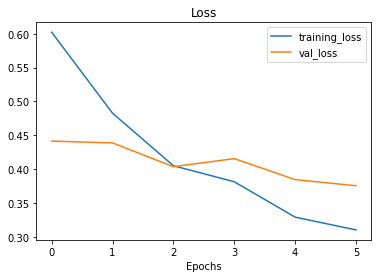

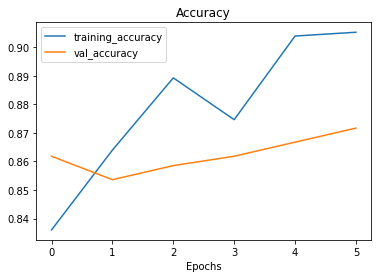

In [56]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_model_2_fine)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [57]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Make plot for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

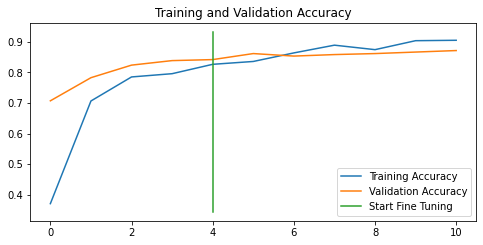

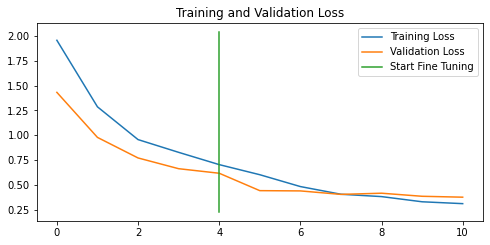

In [58]:
compare_historys(history_model_2, history_model_2_fine)

## Model 4: Fine-tuning an existing model on all of the data

In [59]:
# Download and unzip 10 classes of Food101 data with all images
# import wget
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip")
# unzip_data("10_food_classes_all_data.zip")

In [60]:
# Setup training and test dirs
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [61]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [62]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for the previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [63]:
# Evaluate model_2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 29s 372ms/step - loss: 0.4020 - accuracy: 0.8620


[0.40198948979377747, 0.8619999885559082]

In [64]:
results_10_percent_fine_tune

[0.40198957920074463, 0.8619999885559082]

To train a fine-tuningmodel (model_4) we need to revert model_2 back to it's feature extraction weights.

In [65]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [66]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 29s 371ms/step - loss: 0.6151 - accuracy: 0.8400


[0.6150758266448975, 0.8399999737739563]

In [67]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6150757670402527, 0.8399999737739563]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [68]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [69]:
# Let's drill into our base_model (EfficientNetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [70]:
# Compile
model_2.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

In [71]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_model_4_fine = model_2.fit(train_data_10_classes_full,
                                   epochs=fine_tune_epochs,
                                   validation_data=test_data,
                                   validation_steps=int(0.25 * len(test_data)),
                                   initial_epoch=history_model_2.epoch[-1],  # start training from previous last epoch
                                   callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20221013-150409
Epoch 5/10
235/235 [==============================] - 111s 462ms/step - loss: 0.6429 - accuracy: 0.7968 - val_loss: 0.3554 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 105s 449ms/step - loss: 0.5215 - accuracy: 0.8297 - val_loss: 0.3087 - val_accuracy: 0.9013
Epoch 7/10
235/235 [==============================] - 106s 451ms/step - loss: 0.4677 - accuracy: 0.8492 - val_loss: 0.3049 - val_accuracy: 0.8997
Epoch 8/10
235/235 [==============================] - 105s 447ms/step - loss: 0.4188 - accuracy: 0.8619 - val_loss: 0.2842 - val_accuracy: 0.9046
Epoch 9/10
235/235 [==============================] - 106s 452ms/step - loss: 0.3754 - accuracy: 0.8797 - val_loss: 0.2502 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 104s 443ms/step - loss: 0.3467 - accuracy: 0.8873 - val_loss: 0.2624 - val_accuracy: 0.9128


In [72]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 31s 389ms/step - loss: 0.2698 - accuracy: 0.9124


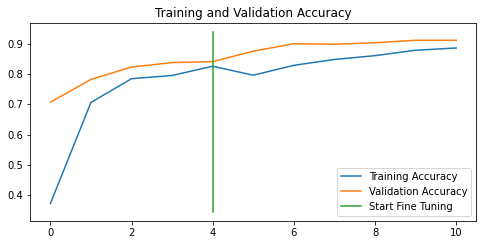

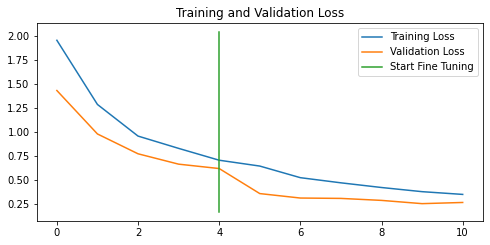

In [73]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_model_2,
                 new_history=history_model_4_fine,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [77]:
# View tensorboard logs of transfer learning modelling experiments
%tensorboard --logdir ./transfer_learning
# Upload TensorBoard dev records (for Colab else could do it in terminal)
"""
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description "A series of different transfer learning experiments with varying amount of data and fine-tuning." \
    --one_shot  # exits the uploader once it's finished uploading
"""

Reusing TensorBoard on port 6006 (pid 13216), started 0:00:18 ago. (Use '!kill 13216' to kill it.)

'\n!tensorboard dev upload --logdir ./transfer_learning     --name "Transfer Learning Experiments with 10 Food101 Classes"     --description "A series of different transfer learning experiments with varying amount of data and fine-tuning."     --one_shot  # exits the uploader once it\'s finished uploading\n'

In [79]:
# View all of your uploaded TensorBoard.dev experiments (public)
# !tensorboard dev list

# To delete an experiment
# !tensorboard dev delete --experiment_id <id_tag>